<center><h1> Automated Detection of Tomato Plant Diseases Using Traditional Machine Learning Techniques </h1></center>

# Importing libraries

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import greycomatrix, greycoprops
from matplotlib import pyplot as plt
%matplotlib inline
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import joblib  # This library is used to save and load models

# Image loading and preprocessing

## Load sample image

In [2]:
sample_img = cv2.imread('4.JPG')

## Convert to grayscale

In [3]:
gs = cv2.cvtColor(sample_img, cv2.COLOR_BGR2GRAY)

## Apply Gaussian blur

In [4]:
blur = cv2.GaussianBlur(gs, (25, 25), 0)

## Otsu's thresholding

In [5]:
ret_otsu, im_bw_otsu = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

## Morphological closing

In [6]:
kernel = np.ones((25, 25), np.uint8)
closing = cv2.morphologyEx(im_bw_otsu, cv2.MORPH_CLOSE, kernel)

# Shape and area analysis

## Extract contours from closing and Otsu

In [7]:
contours_closing, _ = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnt_closing = contours_closing[0]

contours_otsu, _ = cv2.findContours(im_bw_otsu, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnt_otsu = contours_otsu[0]

## Calculate area and perimeter

In [8]:
area_closing = cv2.contourArea(cnt_closing)
perimeter_closing = cv2.arcLength(cnt_closing, True)

area_otsu = cv2.contourArea(cnt_otsu)
perimeter_otsu = cv2.arcLength(cnt_otsu, True)

## Overlay contours on original image

In [9]:
img_with_contours_closing = sample_img.copy()
cv2.drawContours(img_with_contours_closing, [cnt_closing], 0, (0, 255, 0), 2)

img_with_contours_otsu = sample_img.copy()
cv2.drawContours(img_with_contours_otsu, [cnt_otsu], 0, (0, 255, 0), 2)

array([[[126, 129, 143],
        [135, 138, 152],
        [ 90,  93, 107],
        ...,
        [152, 154, 164],
        [158, 160, 170],
        [158, 160, 170]],

       [[119, 122, 136],
        [135, 138, 152],
        [117, 120, 134],
        ...,
        [153, 155, 165],
        [159, 161, 171],
        [160, 162, 172]],

       [[129, 132, 146],
        [117, 120, 134],
        [125, 128, 142],
        ...,
        [153, 155, 165],
        [157, 159, 169],
        [159, 161, 171]],

       ...,

       [[116, 114, 126],
        [ 99,  97, 109],
        [101,  99, 111],
        ...,
        [141, 140, 150],
        [145, 144, 154],
        [147, 146, 156]],

       [[133, 131, 143],
        [111, 109, 121],
        [117, 115, 127],
        ...,
        [151, 150, 160],
        [154, 153, 163],
        [156, 155, 165]],

       [[126, 124, 136],
        [104, 102, 114],
        [121, 119, 131],
        ...,
        [141, 140, 150],
        [143, 142, 152],
        [145, 144, 154]]

## Display images

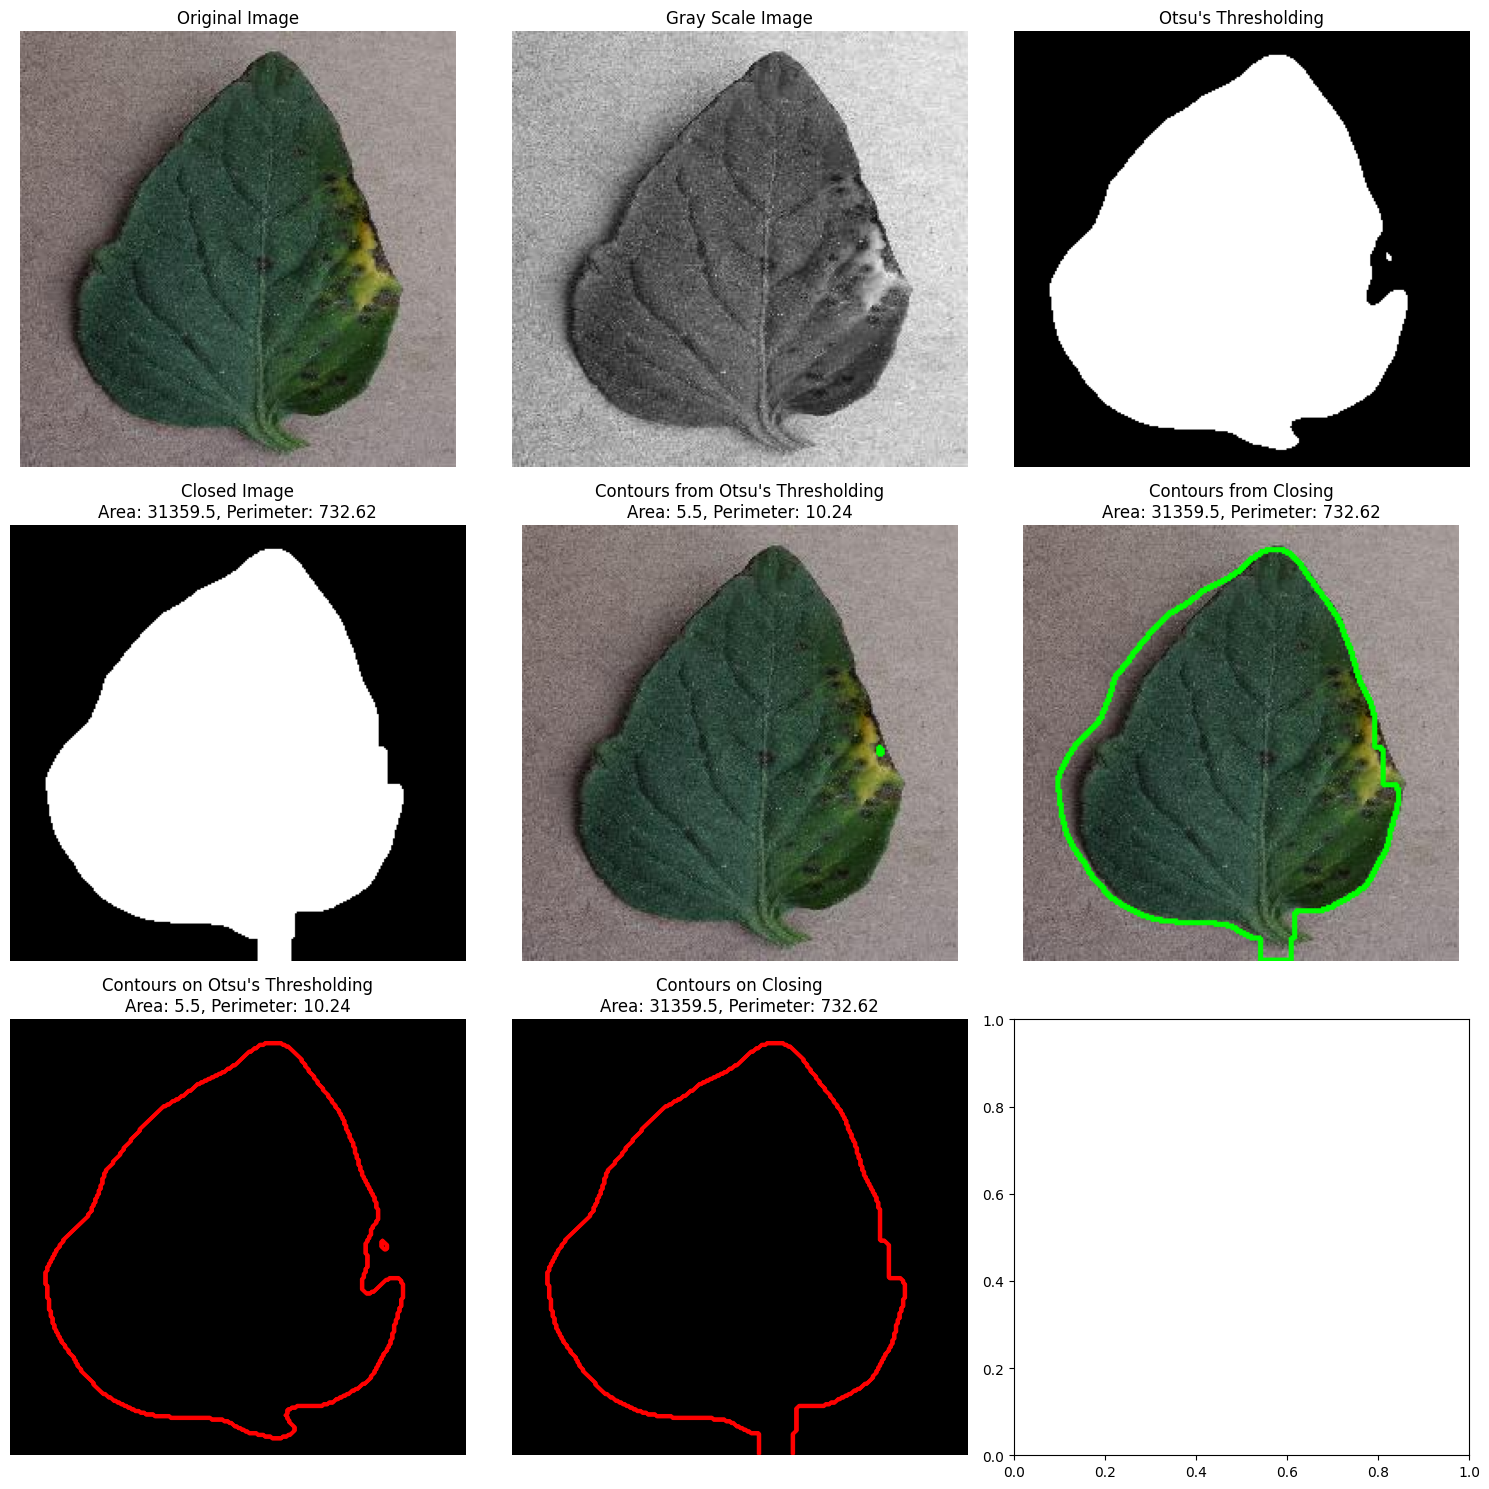

In [10]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

axs[0, 0].imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
axs[0, 0].set_title('Original Image')
axs[0, 0].axis('off')

axs[0, 1].imshow(gs, cmap='gray', aspect='auto')
axs[0, 1].set_title('Gray Scale Image')
axs[0, 1].axis('off')

axs[0, 2].imshow(im_bw_otsu, cmap='gray', aspect='auto')
axs[0, 2].set_title('Otsu\'s Thresholding')
axs[0, 2].axis('off')

axs[1, 0].imshow(closing, cmap='gray', aspect='auto')
axs[1, 0].set_title(f'Closed Image\nArea: {area_closing}, Perimeter: {perimeter_closing:.2f}')
axs[1, 0].axis('off')

axs[1, 1].imshow(cv2.cvtColor(img_with_contours_otsu, cv2.COLOR_BGR2RGB))
axs[1, 1].set_title(f'Contours from Otsu\'s Thresholding\nArea: {area_otsu}, Perimeter: {perimeter_otsu:.2f}')
axs[1, 1].axis('off')

axs[1, 2].imshow(cv2.cvtColor(img_with_contours_closing, cv2.COLOR_BGR2RGB))
axs[1, 2].set_title(f'Contours from Closing\nArea: {area_closing}, Perimeter: {perimeter_closing:.2f}')
axs[1, 2].axis('off')

# Show contours separately
axs[2, 0].imshow(np.zeros_like(gs), cmap='gray', aspect='auto')
axs[2, 0].contour(im_bw_otsu, colors='red', linewidths=2)
axs[2, 0].set_title(f'Contours on Otsu\'s Thresholding\nArea: {area_otsu}, Perimeter: {perimeter_otsu:.2f}')
axs[2, 0].axis('off')

axs[2, 1].imshow(np.zeros_like(gs), cmap='gray', aspect='auto')
axs[2, 1].contour(closing, colors='red', linewidths=2)
axs[2, 1].set_title(f'Contours on Closing\nArea: {area_closing}, Perimeter: {perimeter_closing:.2f}')
axs[2, 1].axis('off')

# Adjust layout for better display
plt.tight_layout()

# Show the plot
plt.show()

# Color analysis

## Separate color channels (red, green, blue)

In [11]:
red_channel = sample_img[:, :, 0]
green_channel = sample_img[:, :, 1]
blue_channel = sample_img[:, :, 2]

## Plot histograms for each channel

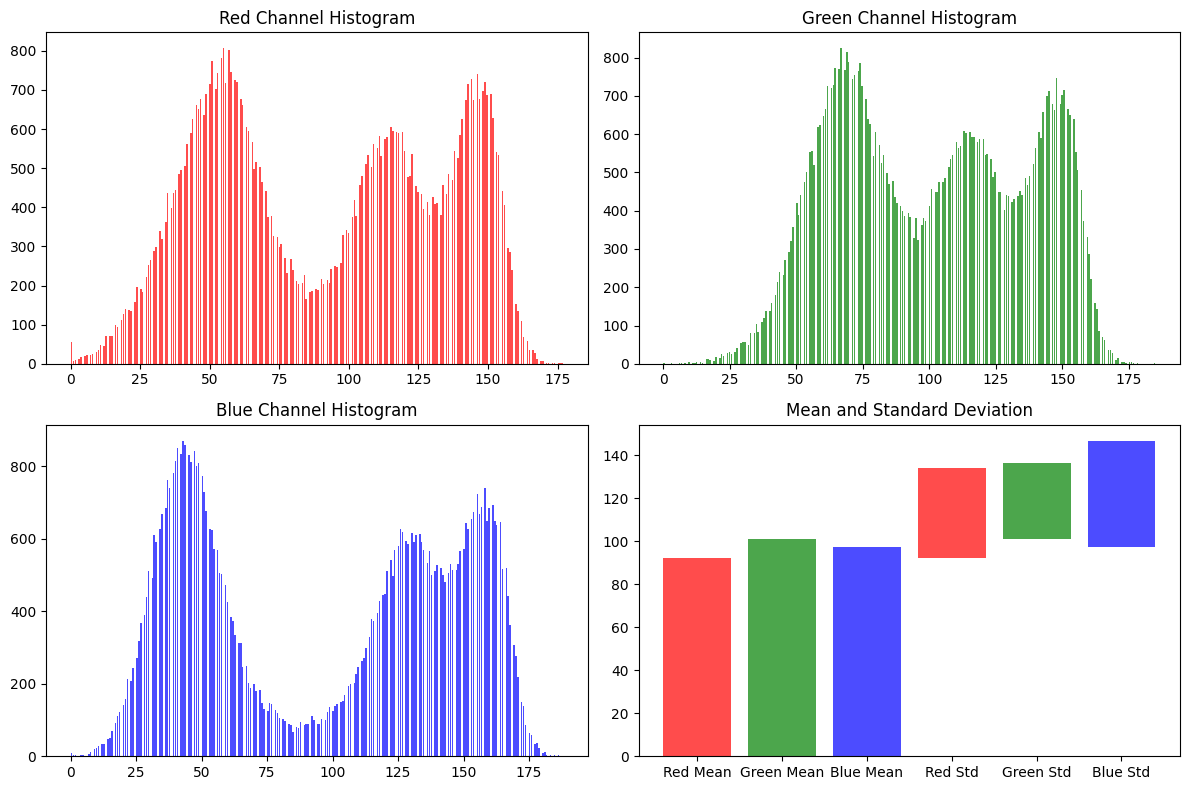

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].hist(red_channel.flatten(), bins=256, color='red', alpha=0.7, rwidth=0.8)
axs[0, 0].set_title('Red Channel Histogram')

axs[0, 1].hist(green_channel.flatten(), bins=256, color='green', alpha=0.7, rwidth=0.8)
axs[0, 1].set_title('Green Channel Histogram')

axs[1, 0].hist(blue_channel.flatten(), bins=256, color='blue', alpha=0.7, rwidth=0.8)
axs[1, 0].set_title('Blue Channel Histogram')

# Plot bar chart for mean and standard deviation
axs[1, 1].bar(['Red Mean', 'Green Mean', 'Blue Mean'], [np.mean(red_channel), np.mean(green_channel), np.mean(blue_channel)], color=['red', 'green', 'blue'], alpha=0.7)
axs[1, 1].bar(['Red Std', 'Green Std', 'Blue Std'], [np.std(red_channel), np.std(green_channel), np.std(blue_channel)], color=['red', 'green', 'blue'], alpha=0.7, bottom=[np.mean(red_channel), np.mean(green_channel), np.mean(blue_channel)])
axs[1, 1].set_title('Mean and Standard Deviation')

# Adjust layout for better display
plt.tight_layout()

# Show the plot
plt.show()

# Edge detection and foreground extraction

## Canny edge detection

In [13]:
edges_canny = cv2.Canny(blur, 50, 150)

## Laplacian edge detection

In [14]:
laplacian = cv2.Laplacian(blur, cv2.CV_64F)
edges_laplacian = np.uint8(np.absolute(laplacian))

## Otsu's thresholding

In [15]:
ret_otsu, im_bw_otsu = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

## Perform morphological closing

In [16]:
kernel = np.ones((15, 15), np.uint8)
closing = cv2.morphologyEx(im_bw_otsu, cv2.MORPH_CLOSE, kernel)

## Find contours on the binary image

In [17]:
contours, _ = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

## Create a mask to store the result

In [18]:
mask = np.zeros_like(gs)
# Draw contours on the mask
cv2.drawContours(mask, contours, -1, (255), thickness=cv2.FILLED)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

## Extract foreground using contour mask

In [19]:
foreground_features = cv2.bitwise_and(sample_img, sample_img, mask=mask)

## Display images at different stages with contours

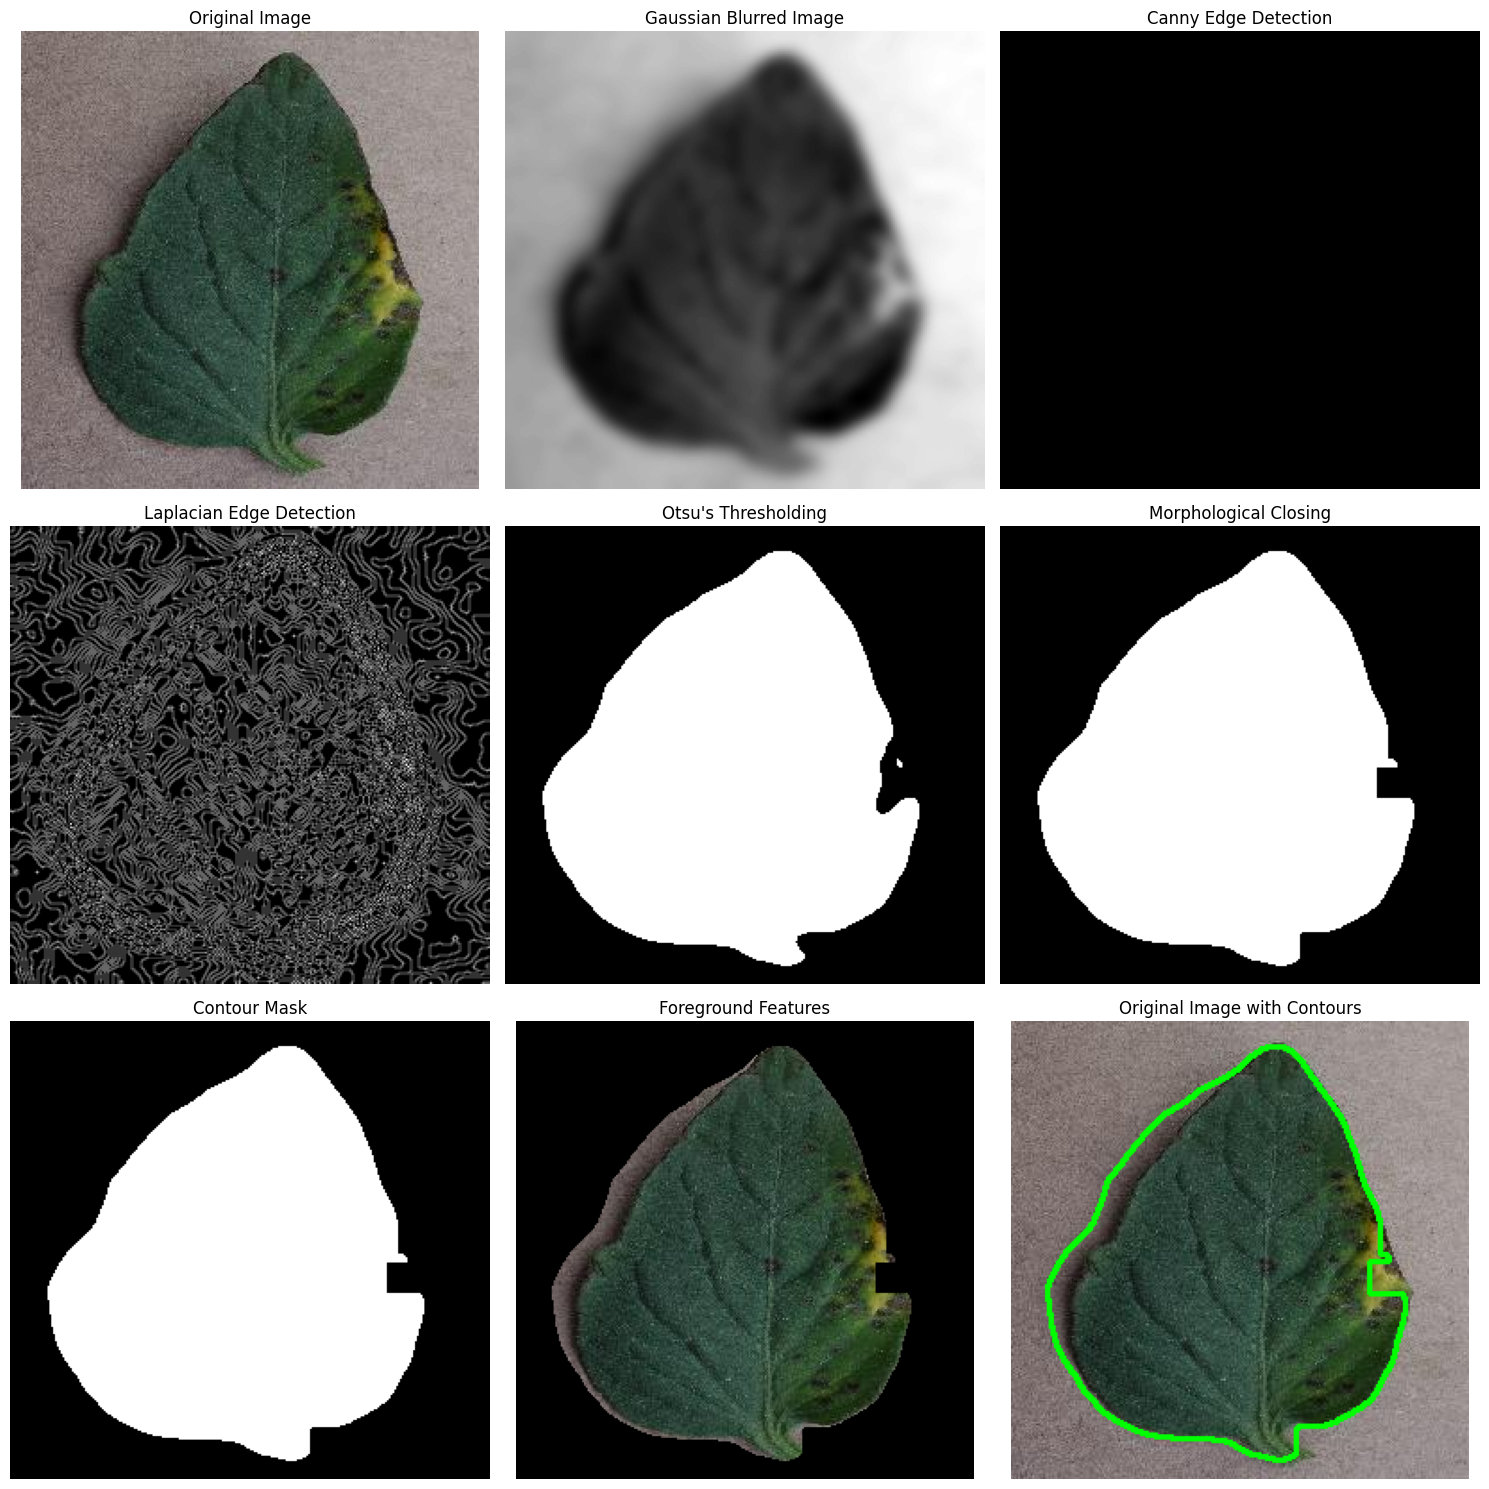

In [20]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

axs[0, 0].imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
axs[0, 0].set_title('Original Image')
axs[0, 0].axis('off')

axs[0, 1].imshow(blur, cmap='gray', aspect='auto')
axs[0, 1].set_title('Gaussian Blurred Image')
axs[0, 1].axis('off')

axs[0, 2].imshow(edges_canny, cmap='gray', aspect='auto')
axs[0, 2].set_title('Canny Edge Detection')
axs[0, 2].axis('off')

axs[1, 0].imshow(edges_laplacian, cmap='gray', aspect='auto')
axs[1, 0].set_title('Laplacian Edge Detection')
axs[1, 0].axis('off')

axs[1, 1].imshow(im_bw_otsu, cmap='gray', aspect='auto')
axs[1, 1].set_title('Otsu\'s Thresholding')
axs[1, 1].axis('off')

axs[1, 2].imshow(closing, cmap='gray', aspect='auto')
axs[1, 2].set_title('Morphological Closing')
axs[1, 2].axis('off')

axs[2, 0].imshow(mask, cmap='gray', aspect='auto')
axs[2, 0].set_title('Contour Mask')
axs[2, 0].axis('off')

axs[2, 1].imshow(cv2.cvtColor(foreground_features, cv2.COLOR_BGR2RGB))
axs[2, 1].set_title('Foreground Features')
axs[2, 1].axis('off')

# Draw contours on the original image
img_with_contours = sample_img.copy()
cv2.drawContours(img_with_contours, contours, -1, (0, 255, 0), 2)

# Display the original image with contours
axs[2, 2].imshow(cv2.cvtColor(img_with_contours, cv2.COLOR_BGR2RGB))
axs[2, 2].set_title('Original Image with Contours')
axs[2, 2].axis('off')

plt.tight_layout()
plt.show()


## Calculate mean and standard deviation

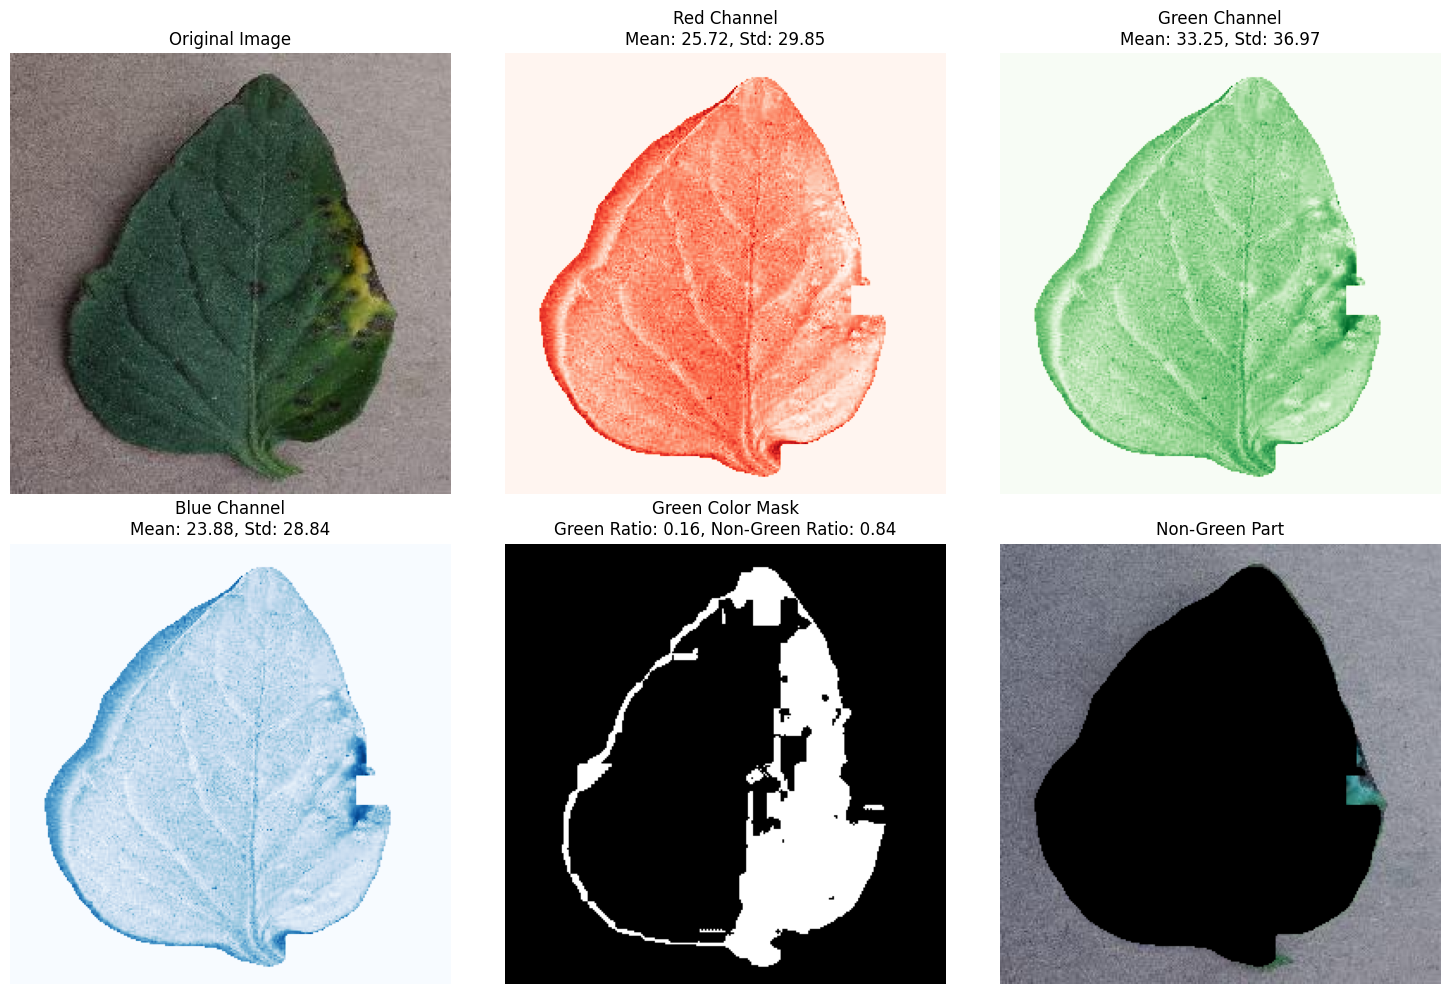

In [21]:
# Visualize color features separately for sample_img
current_frame = sample_img.copy()
filtered_image = closing / 255

# Elementwise Multiplication of range-bounded filtered_image with current_frame
current_frame[:, :, 0] = np.multiply(current_frame[:, :, 0], filtered_image)
current_frame[:, :, 1] = np.multiply(current_frame[:, :, 1], filtered_image)
current_frame[:, :, 2] = np.multiply(current_frame[:, :, 2], filtered_image)

# Color features
red_channel = current_frame[:, :, 0]
green_channel = current_frame[:, :, 1]
blue_channel = current_frame[:, :, 2]

red_mean = np.mean(red_channel)
green_mean = np.mean(green_channel)
blue_mean = np.mean(blue_channel)

# Standard deviation for color feature from the image.
red_std = np.std(red_channel)
green_std = np.std(green_channel)
blue_std = np.std(blue_channel)

# Amount of green color in the image
gr = cv2.cvtColor(current_frame, cv2.COLOR_BGR2HSV)
boundaries = [([30, 0, 0], [70, 255, 255])]
for (lower, upper) in boundaries:
    mask = cv2.inRange(gr, (36, 0, 0), (70, 255, 255))
    ratio_green = cv2.countNonZero(mask) / (current_frame.size / 3)
    f1 = np.round(ratio_green, 2)
# Amount of non-green part of the image
f2 = 1 - f1

# Display color features separately
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Display original image
axs[0, 0].imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
axs[0, 0].set_title('Original Image')
axs[0, 0].axis('off')

# Display red channel
axs[0, 1].imshow(red_channel, cmap='Reds')
axs[0, 1].set_title(f'Red Channel\nMean: {red_mean:.2f}, Std: {red_std:.2f}')
axs[0, 1].axis('off')

# Display green channel
axs[0, 2].imshow(green_channel, cmap='Greens')
axs[0, 2].set_title(f'Green Channel\nMean: {green_mean:.2f}, Std: {green_std:.2f}')
axs[0, 2].axis('off')

# Display blue channel
axs[1, 0].imshow(blue_channel, cmap='Blues')
axs[1, 0].set_title(f'Blue Channel\nMean: {blue_mean:.2f}, Std: {blue_std:.2f}')
axs[1, 0].axis('off')

# Display green color mask
axs[1, 1].imshow(mask, cmap='gray')
axs[1, 1].set_title(f'Green Color Mask\nGreen Ratio: {f1:.2f}, Non-Green Ratio: {f2:.2f}')
axs[1, 1].axis('off')

# Display non-green color part
axs[1, 2].imshow(sample_img - current_frame)
axs[1, 2].set_title('Non-Green Part')
axs[1, 2].axis('off')

# Adjust layout for better display
plt.tight_layout()

# Show the plot
plt.show()


# Foreground color analysis

## Analyze color features (mean and standard deviation) on the foreground

In [22]:
red_channel_fg = foreground_features[:, :, 0]
green_channel_fg = foreground_features[:, :, 1]
blue_channel_fg = foreground_features[:, :, 2]

## Visualize color features separately

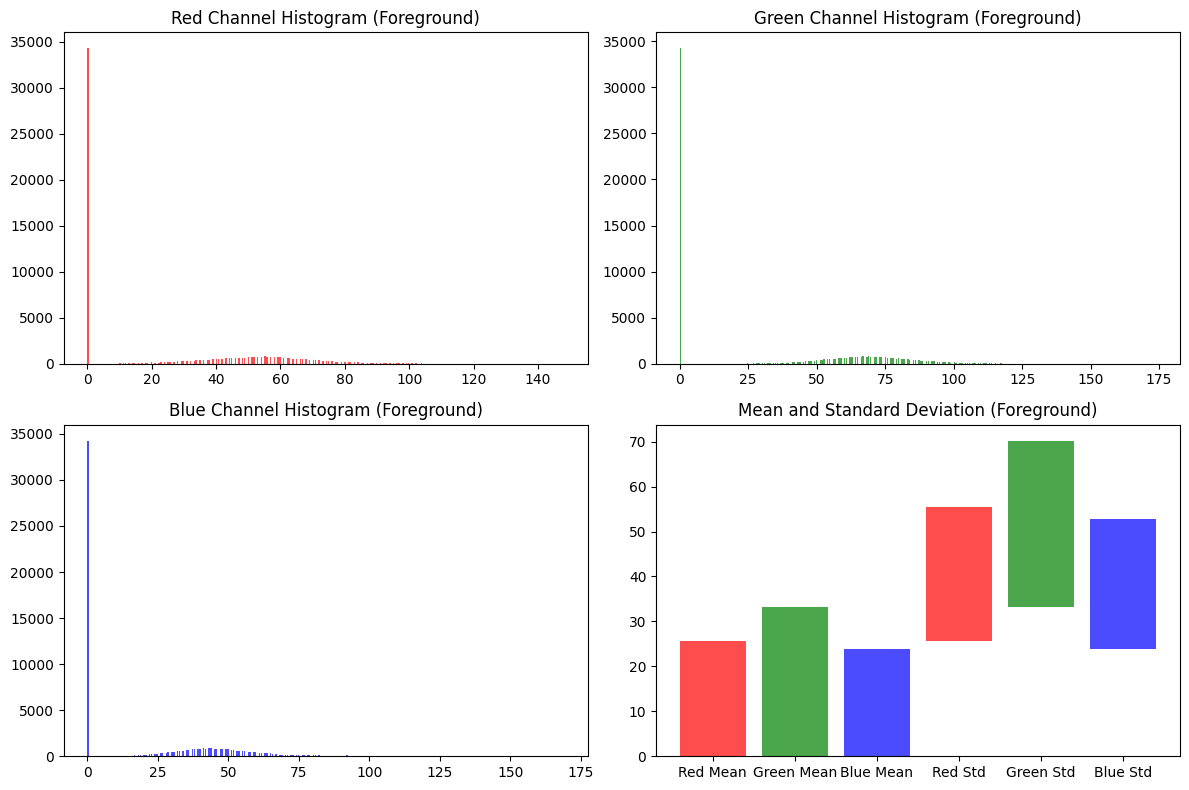

In [23]:
# Plot histograms for each color channel in the foreground
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].hist(red_channel_fg.flatten(), bins=256, color='red', alpha=0.7, rwidth=0.8)
axs[0, 0].set_title('Red Channel Histogram (Foreground)')

axs[0, 1].hist(green_channel_fg.flatten(), bins=256, color='green', alpha=0.7, rwidth=0.8)
axs[0, 1].set_title('Green Channel Histogram (Foreground)')

axs[1, 0].hist(blue_channel_fg.flatten(), bins=256, color='blue', alpha=0.7, rwidth=0.8)
axs[1, 0].set_title('Blue Channel Histogram (Foreground)')

# Plot bar chart for mean and standard deviation in the foreground
axs[1, 1].bar(['Red Mean', 'Green Mean', 'Blue Mean'], [np.mean(red_channel_fg), np.mean(green_channel_fg), np.mean(blue_channel_fg)], color=['red', 'green', 'blue'], alpha=0.7)
axs[1, 1].bar(['Red Std', 'Green Std', 'Blue Std'], [np.std(red_channel_fg), np.std(green_channel_fg), np.std(blue_channel_fg)], color=['red', 'green', 'blue'], alpha=0.7, bottom=[np.mean(red_channel_fg), np.mean(green_channel_fg), np.mean(blue_channel_fg)])
axs[1, 1].set_title('Mean and Standard Deviation (Foreground)')

# Adjust layout for better display
plt.tight_layout()

# Show the plot
plt.show()


# Texture analysis

## Calculate texture features using greycomatrix

C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimag

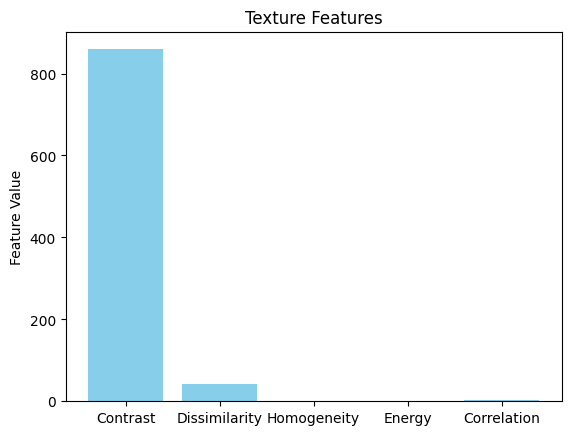

In [24]:
# Texture features using grey level co-occurrence matrix
img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2GRAY)
g = greycomatrix(img, [1], [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4])

# Extract texture features
contrast = greycoprops(g, 'contrast')
dissimilarity = greycoprops(g, prop='dissimilarity')
homogeneity = greycoprops(g, prop='homogeneity')
energy = greycoprops(g, prop='energy')
correlation = greycoprops(g, prop='correlation')

# Combine texture features into a list
texture_features = [
    contrast[0][0] + contrast[0][1] + contrast[0][2] + contrast[0][3],
    dissimilarity[0][0] + dissimilarity[0][1] + dissimilarity[0][2] + dissimilarity[0][3],
    homogeneity[0][0] + homogeneity[0][1] + homogeneity[0][2] + homogeneity[0][3],
    energy[0][0] + energy[0][1] + energy[0][2] + energy[0][3],
    correlation[0][0] + correlation[0][1] + correlation[0][2] + correlation[0][3]
]

# Define feature names
feature_names = ['Contrast', 'Dissimilarity', 'Homogeneity', 'Energy', 'Correlation']

# Create a bar plot
plt.bar(feature_names, texture_features, color='skyblue')
plt.title('Texture Features')
plt.ylabel('Feature Value')
plt.show()


# Feature extraction function

In [25]:
import cv2
import pandas as pd
import numpy as np
from skimage.feature import greycomatrix, greycoprops

# Function to Create a new dataframe
def create_empty_df():
    df = pd.DataFrame()
    df['area'] = None
    df['perimeter'] = None
    df['red_mean'] = None
    df['green_mean'] = None
    df['blue_mean'] = None
    df['f1'] = None
    df['f2'] = None
    df['red_std'] = None
    df['green_std'] = None
    df['blue_std'] = None
    df['f4'] = None
    df['f5'] = None
    df['f6'] = None
    df['f7'] = None
    df['f8'] = None
    df['label'] = None
    return df

# Function to extract the features
def feature_extractor(image):
    '''
    input params: 
    image : NumPy array representing the image

    Output params:
    l : Feature vector
    '''

    try:
        main_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    except:
        return "Invalid"

    # Preprocessing
    gs = cv2.cvtColor(main_img, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gs, (25, 25), 0)
    ret_otsu, im_bw_otsu = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = np.ones((25, 25), np.uint8)
    closing = cv2.morphologyEx(im_bw_otsu, cv2.MORPH_CLOSE, kernel)

    # Shape features
    contours, _ = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    area = cv2.contourArea(cnt)
    if area == 0:
        return "Invalid"
    perimeter = cv2.arcLength(cnt, True)

    current_frame = main_img
    filtered_image = closing / 255

    # Elementwise Multiplication of range bounded filtered_image with current_frame
    current_frame[0:current_frame.shape[0], 0:current_frame.shape[1], 0] = np.multiply(
        current_frame[0:current_frame.shape[0], 0:current_frame.shape[1], 0], filtered_image
    )  # B channel
    current_frame[0:current_frame.shape[0], 0:current_frame.shape[1], 1] = np.multiply(
        current_frame[0:current_frame.shape[0], 0:current_frame.shape[1], 1], filtered_image
    )  # G channel
    current_frame[0:current_frame.shape[0], 0:current_frame.shape[1], 2] = np.multiply(
        current_frame[0:current_frame.shape[0], 0:current_frame.shape[1], 2], filtered_image
    )  # R channel

    img = current_frame

    # Color features
    red_channel = img[:, :, 0]
    green_channel = img[:, :, 1]
    blue_channel = img[:, :, 2]

    red_mean = np.mean(red_channel)
    green_mean = np.mean(green_channel)
    blue_mean = np.mean(blue_channel)

    # standard deviation for color feature from the image.
    red_std = np.std(red_channel)
    green_std = np.std(green_channel)
    blue_std = np.std(blue_channel)

    # amt. of green color in the image
    gr = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    boundaries = [([30, 0, 0], [70, 255, 255])]
    for (lower, upper) in boundaries:
        mask = cv2.inRange(gr, (36, 0, 0), (70, 255, 255))
        ratio_green = cv2.countNonZero(mask) / (img.size / 3)
        f1 = np.round(ratio_green, 2)
    # amt. of non-green part of the image
    f2 = 1 - f1

    # Texture features using grey level co-occurrence matrix
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    g = greycomatrix(img, [1], [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4])

    # with the help of glcm find the contrast
    contrast = greycoprops(g, 'contrast')
    f4 = contrast[0][0] + contrast[0][1] + contrast[0][2] + contrast[0][3]

    # with the help of glcm find the dissimilarity
    dissimilarity = greycoprops(g, prop='dissimilarity')
    f5 = dissimilarity[0][0] + dissimilarity[0][1] + dissimilarity[0][2] + dissimilarity[0][3]

    # with the help of glcm find the homogeneity
    homogeneity = greycoprops(g, prop='homogeneity')
    f6 = homogeneity[0][0] + homogeneity[0][1] + homogeneity[0][2] + homogeneity[0][3]

    energy = greycoprops(g, prop='energy')
    f7 = energy[0][0] + energy[0][1] + energy[0][2] + energy[0][3]

    correlation = greycoprops(g, prop='correlation')
    f8 = correlation[0][0] + correlation[0][1] + correlation[0][2] + correlation[0][3]

    l = [area, perimeter, red_mean, green_mean, blue_mean,
         f1, f2, red_std, green_std, blue_std,
         f4, f5, f6, f7, f8]
    return l

# Dataset creation and feature extraction

In [26]:
# Create an empty DataFrame
df = create_empty_df()

In [27]:
# the root directory of the dataset
root_dir = 'Dataset/train'

# Iterate through each folder in the root directory
for label_folder in os.listdir(root_dir):
    label = label_folder  # the folder name is the label
    label_path = os.path.join(root_dir, label_folder)
    
    # Iterate through each image in the label folder
    for image_file in os.listdir(label_path):
        image_path = os.path.join(label_path, image_file)
        image = cv2.imread(image_path)
        
        # Extract features and write to DataFrame
        features = feature_extractor(image)
        if features != "Invalid":
            features.append(label)  # Append label to feature vector
            df.loc[len(df)] = features



C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimag

C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimag

C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimag

C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimag

C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimag

C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\

C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimag

C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimag

C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimag

C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimag

C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimag

C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\

C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimag

C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimag

C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimag

C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimag

C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimag

C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimag

C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimag

C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimag

C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimag

C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\

C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimag

C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimag

C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimag

C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimag

C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimag

C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimag

C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimag

C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimag

KeyboardInterrupt: 

In [ ]:
# Save DataFrame as CSV file
df.to_csv('Tomato_Dataset.csv', index=False)

# Model Training and Evaluation:

In [28]:
# Import necessary libraries
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Load the dataset
df = pd.read_csv('Tomato_Dataset.csv')

# Separate features and labels
X = df.drop('label', axis=1)
y = df['label']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# PCA for feature extraction
pca = PCA(n_components=10)  # Choose the number of components
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train Random Forest on PCA-transformed features
random_forest_pca = RandomForestClassifier()
random_forest_pca.fit(X_train_pca, y_train)

# Make predictions on the test set
y_pred_pca = random_forest_pca.predict(X_test_pca)

# Evaluate the model on the testing set
test_accuracy_pca = accuracy_score(y_test, y_pred_pca)
print(f'Random Forest with PCA: Accuracy on Testing Set: {test_accuracy_pca:.4f}')

# LDA for feature extraction
lda = LinearDiscriminantAnalysis(n_components=2)  # Choose the number of components
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

# Train Random Forest on LDA-transformed features
random_forest_lda = RandomForestClassifier()
random_forest_lda.fit(X_train_lda, y_train)

# Make predictions on the test set
y_pred_lda = random_forest_lda.predict(X_test_lda)

# Evaluate the model on the testing set
test_accuracy_lda = accuracy_score(y_test, y_pred_lda)
print(f'Random Forest with LDA: Accuracy on Testing Set: {test_accuracy_lda:.4f}')


Random Forest with PCA: Accuracy on Testing Set: 0.8360
Random Forest with LDA: Accuracy on Testing Set: 0.5596


In [14]:
# Load the dataset
df = pd.read_csv('Tomato_Dataset.csv')

# Separate features and labels
X = df.drop('label', axis=1)
y = df['label']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest classifier on the entire training set
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)


RandomForestClassifier()

In [15]:
# Save the trained model to a file
model_filename = 'random_forest_model.joblib'
joblib.dump(random_forest, model_filename)
print(f"Random Forest model saved to {model_filename}")

Random Forest model saved to random_forest_model.joblib


In [16]:
# Evaluate the model on the testing set
y_pred = random_forest.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f'Random Forest: Accuracy on Testing Set: {test_accuracy:.4f}')

Random Forest: Accuracy on Testing Set: 0.8138


In [30]:
# Load the trained Random Forest model
model_filename = 'random_forest_model.joblib'
random_forest = joblib.load(model_filename)

# Read the new image
image_path = 'Dataset/valid/Tomato___Septoria_leaf_spot/0a25f893-1b5f-4845-baa1-f68ac03d96ac___Matt.S_CG 7863_180deg.JPG'  # Replace with the actual path to your image
new_image = cv2.imread(image_path)

# Extract features from the new image
new_features = feature_extractor(new_image)

# Reshape the features into a 2D array
new_features_reshaped = np.array(new_features).reshape(1, -1)

# Make predictions on the new features
prediction = random_forest.predict(new_features_reshaped)

# Display the prediction
print("Prediction for the new image:", prediction[0])


Prediction for the new image: Tomato___Septoria_leaf_spot


C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\pc\anaconda3\lib\site-packages\skimag